#Redes Neuronales - Trabajo Práctico Número 1
#Autor: Franco Scapolla

# Notebook 2: Regresión Softmax

#Introducción

El objetivo de esta notebook es entrenar un modelo de regresión softmax usando nuevamente el dataset de FASION-MNIST. La regresión softmax es una generalización de la regresión lineal para los casos en donde hay más de dos clases para clasificar.


Consideremos un problema de clasificación con $K$ clases. La idea es la siguiente: dada una instancia $\vec{x}$, el modelo primero calcula un puntaje (o _score_) $s_k(\vec{x})$ para cada clase $k$ ($0\leq k \leq K-1$). Luego, calcula la probabilidad de que esa instancia pertenezca a cada clase aplicando la función softmax al respectivo puntaje.

El puntaje para cada clase se calcula según $s_k(\vec{x})=\vec{x}^{T}\theta^{(k)}$, donde $\theta^{(k)}=(\theta_0^{(k)}, \theta_1^{(k)},...,\theta_n^{(k)})^{T}$ es el vector que contiene los pesos o parámetros asociados a la clase $k$.

Si llamo $\hat{p}_k$ a la estimación de la probabilidad de que la instancia $\vec{x}$ pertenezca a la clase $k$, luego puedo escribir $\hat{p}_k$ como la función softmax dada por $\hat{p}_k=\sigma(\vec{s}(\vec{x}))_k=\frac{exp(s_k(\vec{x}))}{\sum_{j=1}^{K}exp(s_j(\vec{x}))}$, donde $\vec{s}(\vec{x})$ es un vector que contiene los puntajes de la instancia $\vec{x}$ para cada clase $k$.

De la misma forma que la regresión logística, la regresión softmax predice la clase con la mayor probabilidad. Es decir, predice $\hat{y}=k$ con el $k$ que maximice el valor de $\hat{p}_k$.

La función de costo es la entropía cruzada (o *cross_entropy*) dada por $J(\vec{\Theta})=\frac{-1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_k^{(i)}log(\hat{p}_k^{(i)})$, donde $y_k^{(i)}$ representa la probabilidad de que la i-ésima instancia pertenezca a la clase $k$. Se ve que si $K=2$ se obtiene la entropía cruzada binaria, que es la función de costo para la regresión lineal.


# Requerimientos del clasificador

* Métrica principal: Accuracy (se busca un Accuracy mayor a $0.7$)
* Métricas secundarias: curva ROC, área bajo curva ROC, F1-Score, Precision, Recall.



# 2.1 Importe de librerías y carga y preprocesamiento de datos

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import model_selection
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [ ]:
#Se cargan las imágenes (si uno quiere correr la notebook por su cuenta, modificar acá el path para que levante las imágenes desde donde corresponda).
x_train = np.load("/content/drive/MyDrive/Redes Neuronales/TP1/train_images.npy")
x_train.shape

(60000, 28, 28)

In [ ]:
#Se cargan los labels asociados a las imágenes (también modificar el path según corresponda acá en cado de querer correr la notebook).
y_train = pd.read_csv("/content/drive/MyDrive/Redes Neuronales/TP1/train_labels.csv")
y_train.describe()

,label
count,60000.000000
mean,4.500000
std,2.872305
min,0.000000
25%,2.000000
50%,4.500000
75%,7.000000
max,9.000000


In [ ]:
#Normalizar las intensidades a valores entre 0 y 1
x_train_scaled = x_train / 255.0
x_train_scaled.shape

(60000, 28, 28)

In [ ]:
#Creo una lista con las distintas clases por comodidad
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# 2.2 Separación del conjunto de entrenamiento y validación

In [ ]:
#Tomo 48000 imágenes para train y 12000 para validation 
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train['label'], test_size=0.2, random_state=42, shuffle=True) 

print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Training images shape: (48000, 784)
Training labels shape: (48000,)
Validation images shape: (12000, 784)
Validation labels shape: (12000,)


# 2.3 Regresión Softmax Test #1


Para esta primer prueba, tomo un modelo LogisticRegression de scikit-learn linear_models y uso sag como solver y multinomial como estrategia multiclase.




In [ ]:
#Creo el modelo
model_1 = LogisticRegression(solver="sag", multi_class="multinomial", max_iter=1000)

In [ ]:
#Entreno el modelo
model_1.fit(x_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', solver='sag')

In [ ]:
#Hago predicciones con el modelo
y_pred = model_1.predict(x_val)

In [ ]:
#Calculo el accuracy del modelo
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.85025


Se observa que se obtiene un accuracy del $85\%$, por lo que este modelo cumple con lo buscado.

Ahora se calculan las métricas secundarias.

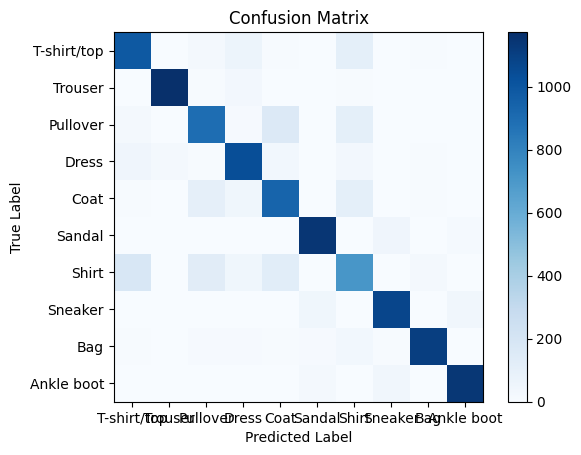

In [ ]:
#Grafico la matriz de confusión
cm = confusion_matrix(y_val, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = class_names
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Se observa que la mayor confusión parece darse entre *shirt* y *t-shirt*, lo cual tiene sentido ya que esas prendas son las más similares. Además, se nota un grado de confusión apreciable entre otras prendas de vestir "similares". Por ejemplo, entre *shirt*, *dress* y *pullover*.

In [ ]:
#Ahora calculo los valores de precision, recall, y F1Score para cada clase. Luego calculo el macro-average
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1202
           1       0.98      0.96      0.97      1219
           2       0.76      0.75      0.75      1205
           3       0.84      0.88      0.86      1184
           4       0.74      0.78      0.76      1202
           5       0.94      0.94      0.94      1211
           6       0.64      0.58      0.61      1218
           7       0.92      0.93      0.92      1159
           8       0.95      0.92      0.94      1197
           9       0.95      0.95      0.95      1203

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



Se observa que el menor valor de precision, recall, y F1 Score es para la clase 6, o sea para la clase *shirt*. Esto se condice con lo observado en la matriz de confusión, en donde se observó una superposición notable entre la clase *shirt* y las otras clases representando prendas de vestir similares.

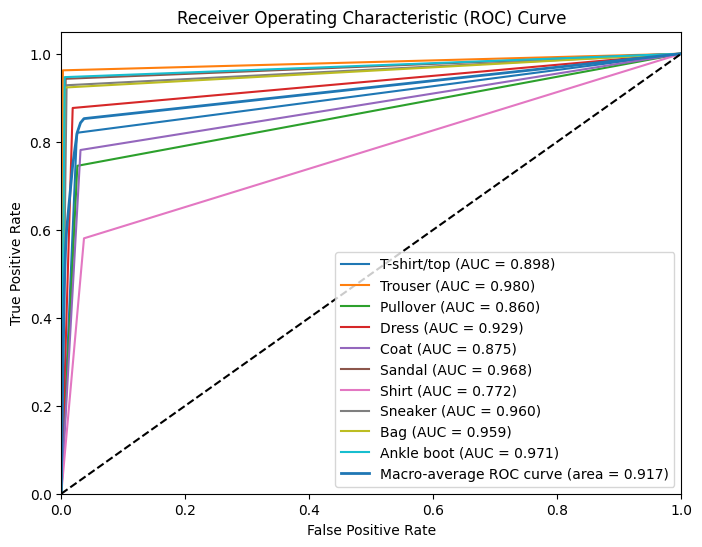

In [ ]:
#Ahora grafico la curva ROC para cada clase, y calculo el área debajo de cada curva (referencia: https://stackoverflow.com/questions/70278059/plotting-the-roc-curve-for-a-multiclass-problem)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve((y_val == i).astype(int), (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(10)]))
tpr_macro = np.zeros_like(fpr_macro)
for i in range(10):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 10
roc_auc_macro = auc(fpr_macro, tpr_macro)


plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC curve (area = {roc_auc_macro:0.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

El menor área lo tiene la clase *shirt*, lo cual era lo esperado luego de observar la matriz de confusión y los valores de precision y recall.

#2.4 Regresión Softmax Test #2


Pruebo ahora con un modelo SGDRegression de sckikit-learn linear_model.

In [ ]:
#Creo el modelo
model_2 = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)

In [ ]:
#Entreno el modelo
model_2.fit(x_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [ ]:
#Hago predicciones con el modelo
y_pred = model_2.predict(x_val)

In [ ]:
#Calculo el accuracy del modelo
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.8410833333333333


El valor de accuracy obtenido es similar al del modelo anterior.